In [1]:
# imports
import numpy as np
from scipy.stats import norm
from filterpy.stats import gaussian, plot_gaussian_pdf
import matplotlib.pyplot as plt

# SOT algorithms
## Why not use original SOT recursion equations?
It is intractable to compute the posterior density $p(x_k|Z_{1:k})$ exactly, since the complexity of the original SOT recursions grow exponentially due to the number of hypothesis sequences at $k$ being $\prod_{i=1}^{k}(m_i + 1)$ where $m_i$ is the number of hypotheses at time $k=i$. It means that the amount of components grow with $k$ and each time step will require more processing time and memory. The components are, namely, weights (hypothesis probabilites) and pdfs (hypothesis priors/posteriors calculated by Kalman filter predict/update steps). In the following we are going to discuss few common strategies to approximate the posterior and obtain a feasible SOT algorithm. The main focus of the following are the posteriors that can be approximated by the gaussian mixture, although the principles will apply more generally.

## Types of algorithms
The approximation boils down to the reduction of the amount of components in $p(x_k|Z_{1:k})$ to obtain a Gaussina mixture with fewer componens $\hat{p}(x_k|Z_{1:k})$ so that $p(x_k|Z_{1:k}) \approx \hat{p}(x_k|Z_{1:k})$. there are two main techniques to reduce a mixture - **pruning** and **merging**.

- pruning - remove unlikely hypothesis with small weights (and renormalize)
- merging - approximate all components by a single density

### Pruning and merging example
$p(x)$ is given by $p(x) = w_1p_1(x) + w_2p_2(x)$ where:

$$
\begin{cases}
w_1 = 0.07 & p_1(x) = \mathcal{N}(x:-2,1) \\
w_2 = 0.93 & p_2(x) = \mathcal{N}(x:2,1.5) \\
\end{cases}
$$

Pruning first hypothesis gives $\hat{p} = p_2(x)$

Merging gives

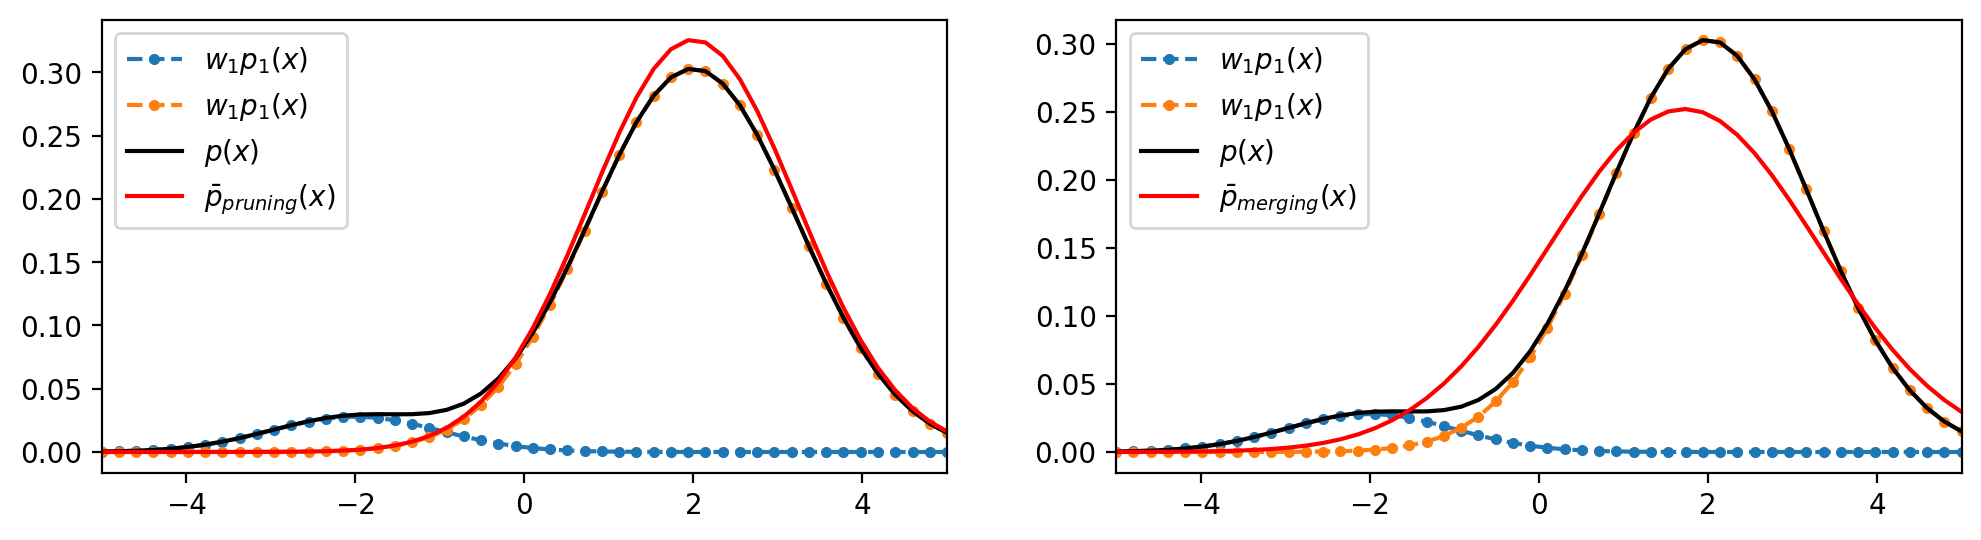

In [2]:
xs = np.linspace(-5, 5, 50)
w = [0.07, 0.93]

get_pdf = lambda x, m, v: norm.pdf(x, m, np.sqrt(v))
p_1 = get_pdf(xs, -2, 1)
p_2 = get_pdf(xs, 2, 1.5)
p_exact = w[0] * p_1 + w[1] * p_2
p_pruning = p_2
mm = w[0] * -2 + w[1] * 2
vm = (w[0] * (1 + (-2)**2) + w[1] * (1.5 + (2)**2)) - mm ** 2
p_merging = get_pdf(xs, mm, vm)

## plotting
fig=plt.figure(figsize=(12, 3), dpi= 200, facecolor='w', edgecolor='k')
ax = plt.subplot(121, xlim=(-5, 5))
plt.plot(xs, w[0] * p_1, "--.", label=r"$w_1p_1(x)$")
plt.plot(xs, w[1] * p_2, "--.", label=r"$w_1p_1(x)$")
plt.plot(xs, p_exact, "k", label=r"$p(x)$")
plt.plot(xs, p_pruning, "r", label=r"$\bar{p}_{pruning}(x)$")
ax.legend()

ax = plt.subplot(122, xlim=(-5, 5))
plt.plot(xs, w[0] * p_1, "--.", label=r"$w_1p_1(x)$")
plt.plot(xs, w[1] * p_2, "--.", label=r"$w_1p_1(x)$")
plt.plot(xs, p_exact, "k", label=r"$p(x)$")
plt.plot(xs, p_merging, "r", label=r"$\bar{p}_{merging}(x)$")
ax.legend()

plt.show()

In the following we are presenting three SOT in clutter algorithms based on above approximation techniques:

- Nearest neighbour (NN) filter uses **pruning**
- Probablistic data association (PDA) filter uses **merging**
- Gaussian sum filter (GSF) uses **pruning/merging**

All of those algorithms are the assumed density filters, meaning that each recursion computation starts and ends with a density of assumed family. For NN and PDA it is Gaussian density and for GSF its a Gaussian mixture density.

## Nearest neigbour (NN) filter
Being assumed density filter the NN filter assumes the Gausian posterior at time $k-1$ which becomes a prior at time $k$.

$$
p(x_{k-1}|Z_{1:k-1}) = \mathcal{N}(x_{k-1}: \bar{x}_{k-1|k-1}, P_{k-1|k-1})
$$

Given the motion model (either linear or non-linear) we can propagate the prior in time and calcluate Kalman filter prediction $p(x_k|Z_{1:k-1})$. Linear case given below:

$$
x_k = F_{k-1}x_{k-1} + q_{k-1}  \\ q_{k-1} \backsim \mathcal{N}(0, Q) \\
p(x_k|Z_{1:k-1}) = \mathcal{N}(x_k:\bar{x}_{k|k-1},P_{k|k-1}) \\
\text{where}
\\
\bar{x}_{k|k-1} = F_{k-1}\bar{x}_{k-1|k-1} \\
P_{k|k-1} = F_{k-1}P_{k-1|k-1}F_{k-1}^T + Q
$$

When its time to perform Kalman filter update, we now have $m_k$ hypotheses, therefore the posterior is the gausian mixture. Furthermore, we denote the nearest neigbour approximation of the predicted density $p^{NN}(x_k|Z_{1:k-1})$, but continue as if it was a true predicted density. We also assume constant probability of detection $P^D(x) = P^D$, linear object measurement model $g_k(o|x) = \mathcal{N}(o: H_kx, R_k)$ and any clutter intensity function $\lambda_c(c)$. The approximation of the Gaussian mixture by one Gaussian density in case of NN is to prune all hypotheses except the most probable one, or in other words, the one with the highest weight.

Algorithm
1. Compute $\tilde{w}_k^{\theta_k}$ for $\theta_k \in \{0,1,...,m_k\}$
2. Find $\theta_k^* = \arg\max_{\theta} \tilde{w}_k^{\theta_k}$
3. Compute by $\bar{x}^{NN}_{k|k} = \hat{x}_k^{\theta_k^*}$ and $P^{NN}_{k|k} = P_k^{\theta_k^*}$ by Kalman filter update
4. Assume posterior $p^{NN}(x_k|Z_{1:k}) = \mathcal{N}(x_k:\bar{x}^{NN}_{k|k},P^{NN}_{k|k})$

### Example
Prior $p(x_1) = \mathcal{N}(x_1:0.5,0.2)$

Object likelihood $g_k(o_k|x_k)=\mathcal{N}(o_k:x_k,0.2)$

Motion model (random walk) $\pi_k(x_k|x_{k-1})=\mathcal{N}(x_k:x_{k-1},0.35)$

Probability of detection $P^D(x) = 0.9$

Clutter intensity 

$$\lambda(c) = \begin{cases} 0.4 &\text{if }|x| \le 4 \\ 0 &\text{otherwise} \end{cases}$$

Sequence of detections $Z_{1:k} = (Z_1, Z_2, ..., Z_k) = \{[-1.3, 1.7],\ [1.3],\ [-0.3, 2.3],\ [-2, 3],\ [2.6],\ [-3.5, 2.8]\}$

In [3]:
from sot.sot import GaussianMixture, update_mixture, predict_mixture
from ipywidgets import interact, IntSlider

Z = [
    [-1.3, 1.7],
    [1.3],
    [-0.3, 2.3],
    [-2, 3],
    [2.8],
    [-3.5, 2.8]
]

lamc = lambda c: 0.4 if np.abs(c) < 4 else 0
    
R = np.array([0.2])
H = np.array([1])
Q = np.array([0.35])
F = np.array([1])
PD = 0.9

priors = [GaussianMixture(
    [np.array(0.5)],
    [np.array(0.5)],
    [np.array(1.0)])]
posteriors = []

priors_nn = [GaussianMixture(
    [np.array([0.5])],
    [np.array([0.5])],
    [np.array(1.0)])]
posteriors_nn = []

# CALCULATE ORIGINAL RECURSION
for k, z in enumerate(Z):
    # update
    xs_u, Ps_u, ws_u = update_mixture(priors[k].xs, priors[k].Ps, priors[k].ws, z, R, H, PD, lamc)
    posteriors.append(GaussianMixture(xs_u, Ps_u, ws_u))
      
    # prediction
    xs_p, Ps_p = predict_mixture(xs_u, Ps_u, F, Q)
    priors.append(GaussianMixture(xs_p, Ps_p, ws_u))

# CALCULATE NN RECURSION
for k, z in enumerate(Z):
    # update
    xs_u, Ps_u, ws_u = update_mixture(priors_nn[k].xs, priors_nn[k].Ps, priors_nn[k].ws, z, R, H, PD, lamc)
    posterior_mixture = GaussianMixture(xs_u, Ps_u, ws_u)
    
    # calculate NN approximation
    xs_unn, Ps_unn = posterior_mixture.get_pruned()
    posteriors_nn.append(GaussianMixture(xs_unn, Ps_unn, [1.0]))
      
    # prediction
    xs_p, Ps_p = predict_mixture(xs_unn, Ps_unn, F, Q)
    priors_nn.append(GaussianMixture(xs_p, Ps_p,[1.0]))

 
xval = np.linspace(-4,4,150)
def plot_nn_filter(k):
    pxz = posteriors[k-1].get_mixture(xval)
    pxz_nn = posteriors_nn[k-1].get_components(xval)
    px_nn = priors_nn[k-1].get_components(xval)
    no_detect = np.dot(priors[k-1].xs, priors[k-1].ws)
    
    plt.figure(figsize=(12, 6), dpi= 200, facecolor='w', edgecolor='k')
    plt.subplot(xlim=(-4,4))
    plt.plot(Z[k-1], np.zeros(len(Z[k-1])), "rs", markersize=10, label=f"$Z_{{{k}}}$")
    plt.plot(no_detect, np.zeros(1), "bs", markersize=10, label=f"no detect: $E(p(x_{{{k}}}|Z_{{1:{k-1}}}))$")
    plt.plot(xval, pxz, "k", label=f"$p(x_{{{k}}}|Z_{{1:{k}}})$")
    plt.plot(xval, pxz_nn, "m", label=f"$p^{{NN}}(x_{{{k}}}|Z_{{1:{k}}})$")
    plt.plot(xval, px_nn, "r", label=f"$p^{{NN}}(x_{{{k}}}|Z_{{1:{k-1}}})$")
    plt.legend()
    plt.show()

    
interact(plot_nn_filter, 
         k=IntSlider(value=1, min=1., max=6, description="timestep k"));

interactive(children=(IntSlider(value=1, description='timestep k', max=6, min=1), Output()), _dom_classes=('wi…

### Pros and cons
+ (+) A fast algorithm which is simple to implement
+ (+) Works well in simple scenarios, very high probability of detection $P^D$ and low clutter intensity $\lambda_c(c)$
+ (-) Ignores some hypotheses and thus underestimates the uncertainties which increases the risk that we will loose track of the object
+ (-) Performs poorly in complicated scenarios

## Probabilistic data association (PDA)
In contranst to NN filter the PDA filter merges all hypotheses into one Gaussian posterior un the update step, and thus takes into account the uncertainties from all hypotheses. the prediction step and the assumptions for the update step are exactly the same as for NN filter. The approximation of the posterior mixture in PDA is performed by finding a Gaussian with the same mean and covariance as the mixture. Such approximation minmizes the Kullback-Leibler divergence and is the best amoing all Gaussian approximations.
$$
p^{PDA}(x_k|Z_{1:k}) = \mathcal{N}(x_k:\bar{x}^{PDA}_{k|k}, P^{PDA}_{k|k}) \\
$$
where the new expected value is the expected value of expected values of Gaussian components:
$$
\bar{x}^{PDA}_{k|k} = \mathbb{E}_{p(x_k|Z_{1:k})}[x_k] = \sum_{\theta_k=0}^{m_k}w_k^{\theta_k}\hat{x}_k^{\theta_k}
$$
amd the new covariance is the sum of covariances of the Gaussian componens and covariance between expected values of the Gaussian components:
$$
P^{PDA}_{k|k} = Cov_{p(x_k|Z_{1:k})}[x_k] = \sum_{\theta_k=0}^{m_k}w_k^{\theta_k}P_k^{\theta_k} + w_k^{\theta_k}(\bar{x}^{PDA}_k - \hat{x}_k^{\theta_k})(\bar{x}^{PDA} - \hat{x}_k^{\theta_k})^T
$$

Algorithm:
1. Compute $\tilde{w}_k^{\theta_k}$, $\hat{x}_k^{\theta_k}$ and $P_k^{\theta_k}$ for $\theta_k \in \{0,1,...,m_k\}$
2. Compute approximations expected value $\bar{x}^{PDA}_{k|k} = \sum_{\theta_k=0}^{m_k}w_k^{\theta_k}\hat{x}_k^{\theta_k}$
3. Compute approximations covariance $P^{PDA}_{k|k} = \sum_{\theta_k=0}^{m_k}w_k^{\theta_k}P_k^{\theta_k} + w_k^{\theta_k}(\bar{x}^{PDA}_k - \hat{x}_k^{\theta_k})(\bar{x}^{PDA} - \hat{x}_k^{\theta_k})^T$

### Examples
Same as example above, but with PDA

In [4]:
priors = [GaussianMixture(
    [np.array(0.5)],
    [np.array(0.5)],
    [np.array(1.0)])]
posteriors = []

priors_pda = [GaussianMixture(
    [np.array([0.5])],
    [np.array([0.5])],
    [np.array(1.0)])]
posteriors_pda = []

# CALCULATE ORIGINAL RECURSION
for k, z in enumerate(Z):
    # update
    xs_u, Ps_u, ws_u = update_mixture(priors[k].xs, priors[k].Ps, priors[k].ws, z, R, H, PD, lamc)
    posteriors.append(GaussianMixture(xs_u, Ps_u, ws_u))
      
    # prediction
    xs_p, Ps_p = predict_mixture(xs_u, Ps_u, F, Q)
    priors.append(GaussianMixture(xs_p, Ps_p, ws_u))

# CALCULATE NN RECURSION
for k, z in enumerate(Z):
    # update
    xs_u, Ps_u, ws_u = update_mixture(priors_pda[k].xs, priors_pda[k].Ps, priors_pda[k].ws, z, R, H, PD, lamc)
    posterior_mixture = GaussianMixture(xs_u, Ps_u, ws_u)
    
    # calculate PDA approximation
    xs_upda, Ps_upda = posterior_mixture.get_merged()
    
    posteriors_pda.append(GaussianMixture(xs_upda, Ps_upda, [1.0]))
      
    # prediction
    xs_p, Ps_p = predict_mixture(xs_upda, Ps_upda, F, Q)
    priors_pda.append(GaussianMixture(xs_p, Ps_p,[1.0]))

 
xval = np.linspace(-4,4,150)
def plot_nn_filter(k):
    pxz = posteriors[k-1].get_mixture(xval)
    pxz_pda = posteriors_pda[k-1].get_components(xval)
    px_pda = priors_pda[k-1].get_components(xval)
    no_detect = np.dot(priors[k-1].xs, priors[k-1].ws)
    
    plt.figure(figsize=(12, 6), dpi= 200, facecolor='w', edgecolor='k')
    plt.subplot(xlim=(-4,4))
    plt.plot(Z[k-1], np.zeros(len(Z[k-1])), "rs", markersize=10, label=f"$Z_{{{k}}}$")
    plt.plot(no_detect, np.zeros(1), "bs", markersize=10, label=f"no detect: $E(p(x_{{{k}}}|Z_{{1:{k-1}}}))$")
    plt.plot(xval, pxz, "k", label=f"$p(x_{{{k}}}|Z_{{1:{k}}})$")
    plt.plot(xval, pxz_pda, "m", label=f"$p^{{PDA}}(x_{{{k}}}|Z_{{1:{k}}})$")
    plt.plot(xval, px_pda, "r", label=f"$p^{{PDA}}(x_{{{k}}}|Z_{{1:{k-1}}})$")
    plt.legend()
    plt.show()

    
interact(plot_nn_filter, 
         k=IntSlider(value=1, min=1., max=6, description="timestep k"));

interactive(children=(IntSlider(value=1, description='timestep k', max=6, min=1), Output()), _dom_classes=('wi…

### Pros and cons
+ (+) A fast algorithm which is simple to implement
+ (+) Works well in simple scenarios, very high probability of detection $P^D$ and low clutter intensity $\lambda_c(c)$
+ (+) Acknowledges uncertainty slightly better than NN
+ (-) Performs poorly in complicated scenarios when the posterior is far from Gaussian

## Gaussian mixture filter (GMF)
The main idea of Gaussian mixture filtering or Gausian sum filtering is to recognize that the approximation of the posterior with the single Gaussian (be it by pruning or merging) is often very crude. Instead we will seek approximating the posteriar with the gaussian mixture with N components. We can often do that because even though the posterior contains many hypothesis, it is usually dominated by only a fraction of those. Lets assume that we end every recursion with a Gaussian mixture with a few components:

$$
p^{GSF}(x_{k-1}|Z_{1:k-1}) = \sum_{h_{k-1}=1}^{\mathcal{H}_{k-1}}w_{k-1}^{h_{k-1}}p_{k-1|k-1}^{h_{k-1}}(x_{k-1})
$$

Assuming linear and Gaussian models, posterior at time $k$ is a Gaussian mixture that considers all the transition hyposesis sequences from previous $\mathcal{H}_{k-1}$ hypotheses to $m_k + 1$ new hypotheses obtained with measurements. The _breve_ $\breve{p}$ notation corresponds to the density before any approximations are applied.

$$
\breve{p}^{GSF}(x_k|Z_{1:k}) = \sum_{h_{k-1}=1}^{\mathcal{H}_{k-1} \cdot (m_k + 1)}\breve{w}_{k}^{h_{k}}\breve{p}_{k|k}^{h_{k}}(x_{k})
$$

How can we limit the amount of hypotheses in {\breve{p}} to get a sufficient approximation. There are 3 strategies:

Algorithm 1: Prune all hypotheses whose weight are smaller than a threshold $\gamma$, re-normalize w}eights and re-assign $\theta$ to be $\{1,2,...,\mathcal{H}_k\}$

1. Input $\gamma$, $w^i$, $\hat{x}^i$, $P^i$ where $i \in \{1,2,...,\mathcal{H}\}$
2. Find indices that we intend to keep $\{ind \ | \ w^i > \gamma \ \forall i \ \in \{1,2,...,\mathcal{H}\}\}$
3. Set $\grave{\mathcal{H}} = |ind|$ and $c = \sum_{i=1}^{\grave{\mathcal{H}}}w^{ind(i)}$
4. For each $i \in \{1,2,...,\grave{\mathcal{H}}\}$ get $\grave{w}^i = \frac{w^{ind(i)}}{c}$, $\grave{x}^i = \hat{x}^{ind(i)}$ and $\grave{P}^i = P^{ind(i)}$

Algorithm 2: Merge similar components:

For example suppose $p^1(x)$ and $p^2(x)$ are similar in the following expression. Set $w^{12} = w^1 + w^2$ and we get.
$$
p(x) = w^1p^1(x) + w^2p^2(x) + w^3p^3(x) = w^{12}\left(\frac{w^1p^1(x)}{w^{12}} + \frac{w^2p^2(x)}{w^{12}}\right) + w^3p^3(x)
$$
The expression in the parentheses can be viewed as $p^{12}(x)$ and obtained using the techniques fro PDA filtering.

Algorithm 3: Prune hypotheses until we are left with at most $N_{max}$ hypotheses

1. Input $N_{max}$, $w^i$, $\hat{x}^i$, $P^i$ where $i \in \{1,2,...,\mathcal{H}\}$
2. If $\mathcal{H}\} > N_{max}$ Find indices that we intend to keep by sorting $ind = sort(\{w^1,w^2,...,w^{\mathcal{H}}\})$
3. Compute normalization factor $c = \sum_{i=1}^{N_{max}}w^{ind(i)}$
4. For each $i \in \{1,2,...,N_{max}\}$ get $\grave{w}^i = \frac{w^{ind(i)}}{c}$, $\grave{x}^i = \hat{x}^{ind(i)}$ and $\grave{P}^i = P^{ind(i)}$

### Estimator for the Gaussian mixture
In case of the posterior approximation that yields single Gaussian it is clear that the state estimate $x_k$ is just the expected value of the Gaussian. However, if the posterior is the Gaussian mixture, how can we estimate $x_k$? 

#### Minimum mean square error (MMSE) estimator
One possibility is to use the minimum mean square error (MMSE) estimation $\bar{x}_{k|k}$ that minimizes $\mathbb{E}[(x_k - \bar{x}_{k|k})^T(x_k - \hat{x}_{k|k})|Z_{1:k}]$. The MMSE estimator is calculated in the same way as the posterior mean in the PDA filtering approximation.

$$
\bar{x}_{k|k} = \mathbb{E}[x_k|Z_{1:k}] = \sum_{h_{k}=1}^{\mathcal{H}_{k}}w_{k}^{h_{k}}\hat{x}_{k|k}^{h_{k}}
$$

#### Most probably hypothesis estimation
Another alternative is to use the estimation of the most probable hypothesis, namely, the hypothesis with the highest weight. More preferable for multi modal densities to ensure that our posterior state estimate doesnt end up somewhere inbetween the modes. Both estimators are identical in case of posterior being a single Gaussian.

### Pros and cons
+ (+) Significantly more accurate than NN and PDA, but that difference is only noticed in medium-difficult settings, namely when the probability of detection is low and clutter is high.
+ (+) Complexity can be adjustted to computational resources by choosing the pruning parameters.
+ (-) More computationally demanding than NN and PDA and somewhat more complicated to implement

### Examples
Same as example previous, but with GSF

In [5]:
N_max = 5
priors = [GaussianMixture(
    [np.array(0.5)],
    [np.array(0.5)],
    [np.array(1.0)])]
posteriors = []

priors_gsf = [GaussianMixture(
    [np.array([0.5])],
    [np.array([0.5])],
    [np.array(1.0)])]
posteriors_gsf = []

# CALCULATE ORIGINAL RECURSION
for k, z in enumerate(Z):
    # update
    xs_u, Ps_u, ws_u = update_mixture(priors[k].xs, priors[k].Ps, priors[k].ws, z, R, H, PD, lamc)
    posteriors.append(GaussianMixture(xs_u, Ps_u, ws_u))
      
    # prediction
    xs_p, Ps_p = predict_mixture(xs_u, Ps_u, F, Q)
    priors.append(GaussianMixture(xs_p, Ps_p, ws_u))

# CALCULATE NN RECURSION
for k, z in enumerate(Z):
    # update
    xs_u, Ps_u, ws_u = update_mixture(priors_gsf[k].xs, priors_gsf[k].Ps, priors_gsf[k].ws, z, R, H, PD, lamc)
    posterior_mixture = GaussianMixture(xs_u, Ps_u, ws_u)
    
    # Choose N best
    xs_ugsf, Ps_ugsf, ws_ugsf = posterior_mixture.get_n_best(N_max)
    posteriors_gsf.append(GaussianMixture(xs_ugsf, Ps_ugsf, ws_ugsf))
      
    # prediction
    xs_p, Ps_p = predict_mixture(xs_ugsf, Ps_ugsf, F, Q)
    priors_gsf.append(GaussianMixture(xs_p, Ps_p,ws_ugsf))

 
xval = np.linspace(-4,4,150)
def plot_nn_filter(k):
    pxz = posteriors[k-1].get_mixture(xval)
    pxz_gsf = posteriors_gsf[k-1].get_mixture(xval)
    px_gsf = priors_gsf[k-1].get_mixture(xval)
    no_detect = np.dot(priors[k-1].xs, priors[k-1].ws)
    
    plt.figure(figsize=(12, 6), dpi= 200, facecolor='w', edgecolor='k')
    plt.subplot(xlim=(-4,4))
    plt.plot(Z[k-1], np.zeros(len(Z[k-1])), "rs", markersize=10, label=f"$Z_{{{k}}}$")
    plt.plot(no_detect, np.zeros(1), "bs", markersize=10, label=f"no detect: $E(p(x_{{{k}}}|Z_{{1:{k-1}}}))$")
    plt.plot(xval, pxz, "k", label=f"$p(x_{{{k}}}|Z_{{1:{k}}})$")
    plt.plot(xval, pxz_gsf, "m-.", label=f"$p^{{PDA}}(x_{{{k}}}|Z_{{1:{k}}})$")
    plt.plot(xval, px_gsf, "r", label=f"$p^{{PDA}}(x_{{{k}}}|Z_{{1:{k-1}}})$")
    plt.legend()
    plt.show()

    
interact(plot_nn_filter, 
         k=IntSlider(value=1, min=1., max=6, description="timestep k"));

interactive(children=(IntSlider(value=1, description='timestep k', max=6, min=1), Output()), _dom_classes=('wi…

As we see in $k = 1$ the posterior is calculate exactly, since there is only 3 hypothesis and we are not pruning anything. At step $k = 2$ there are 6 hypotheses sequences, we will only allow $N_{max} = 5$ so small approximation error can be seen. In the following steps, we see more error between the true and GSF approximated posterior, however the results suggest that GSF performs this task very well.

## Gating
Suppose we have a very good sensor and we would like to apply PDA single object tracking.
- large $P^D$
- small $\lambda_c$
- huge field of view

Under these conditions we can expect our SOT filters to perform well, but the huge field of view comes with the downside of expecting high number of clutter detections $m_k$.

The the essence of PDA is performing a summation over all hypotheses to approximate all of them as a single Gaussian. 

$$
\bar{x}^{PDA}_{k|k}  = \sum_{\theta_k=0}^{m_k}w_k^{\theta_k}\hat{x}_k^{\theta_k}
\\
P^{PDA}_{k|k} = \sum_{\theta_k=0}^{m_k}w_k^{\theta_k}P_k^{\theta_k} + w_k^{\theta_k}(\bar{x}^{PDA}_k - \hat{x}_k^{\theta_k})(\bar{x}^{PDA} - \hat{x}_k^{\theta_k})^T
$$

That summation could be computationally demanding if $m_k$ is sufficiently large. However, for the measurements that are far from the predicted measurement the weights are practically zero and dont contribute to the posterior Gaussian. To save the computation during the update step we would like to avoid computing $w_k^{\theta_k}$, $\hat{x}_k^{\theta_k}$ and $P_k^{\theta_k}$ for hypotheses with $w_k^{\theta_k}\approx 0$. It also means that we want to ignore the measurements that are far from the predicted measurements, which gating is all about. Gating can be though as a pruning method that does not compute the weights. The technique is not specific to PDA, but can be appled generally.

There are few ways to form gates. Simpler types could be an axis alligned box, but we will apply a more popular and sophisticated gate based on a covariance ellipsoid of the predicted measurement distribution. Consider the unnormalized weight.

$$
\tilde{w}_k^{\theta_k} = \frac{P^D(x_k)\mathcal{N}(z_k^{\theta_k}:\bar{z}_{k|k}^{h_{k-1}},S_{k,h_{k-1}})}{\lambda_c(z_k^{\theta_k})}
$$

We note that the weight $\tilde{w}_k^{\theta_k}$ is small when the following Mahalanobis distance between the measurement $z_k^{\theta_k}$ and distribution $\mathcal{N}(z_k^{\theta_k}:\bar{z}_{k|k}^{h_{k-1}},S_{k,h_{k-1}})$ is large (given $\lambda_c \approx \ \text{constant}$).

$$
d_{h_{k-1},\theta_k}^2 = (z_k^{\theta_k} - \bar{z}_{k|k}^{h_{k-1}})^TS_{k,h_{k-1}}^{-1}(z_k^{\theta_k} - \bar{z}_{k|k}^{h_{k-1}})
$$

This allows as to disregard the measurement $z_k^{\theta_k}$ as clutter under the hypothesis $h_{k-1}$ if $d_{h_{k-1},\theta_k}^2 > G$. The selection of the threshold $G$ should be such that the probability the object being selected outside the gate $P_G$ is very small.

$$
P_G = Pr[d_{h_{k-1},\theta_k}^2 > G|h_{k-1},\theta_k]
$$

The distance is chi square distributed $\chi^2(n_z)$ with the number of degrees of freedom equal to dimensionality of the measurement vector.

$$
d_{h_{k-1},\theta_k}^2 > G|h_{k-1},\theta_k \backsim \chi^2(n_z)
$$

A common strategy will be to assume as high $P_G$ value, for example $99.5\%$ and use the chi squared CDF to find the threshold $G$.

### Examples

## Summary


gaussian mixture class?